<h2>TAM Predicition</h2>


<b>Total Addressable Market:</b> Represents revenue opportunity at 100% market share, as if no competition exists

<p><b> Example: </b>An automobile mechanic business services new models of a major car company. The major car company sells approximately 14 million new models per year in the U.S. The mechanic business targets customers in their first year of ownership, so the TAM is 14 million models</p>

<h3> Importing Libraries</h3>

In [27]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import h3

import geopandas as gpd
from keplergl import KeplerGl
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error as mae


<h3>Bookings data</h3>

<p> Contains the information about the user, and the bookings made by them in a particular outlet</p>
<p> Also contains the latitude and longitude from where the bookings were made</p>

In [1]:
with open('all_bookings.pkl','rb') as f:
    data = pickle.load(f)

data['user'] = client_data['user'].astype(str)

In [2]:
data.shape, data['booking_number'].nunique(), data['user'].nunique()

((19684381, 11), 19684381, 407360)

In [1]:
data['type'].value_counts()

In [2]:
data['status'].value_counts()

In [3]:
data['category'].value_counts()

In [3]:
data = client_data[(data['status']=='ACTIVE') & (data['type']!='waitlist')]

<h3> Features</h3>

<p> Features created at a Hex level to be used in the model</p> 

In [24]:
features = pd.read_csv('features.csv')

<h3>Outlet data</h3>

<p> Contains the outlet level information such as category, latitude, longitude, revenue, area, etc.</p>

In [2]:
center_loc = pd.read_csv('store_revenues.csv')
center_loc = center_loc[center_loc['city']=='Bangalore']

center_loc['services'] = center_loc['services'].str.upper()

<h4> Merging the bookings and outlets data, in order to keep only the records for which outlet information is available</h4>

In [18]:
model_data = data.merge(center_loc,on='center_id')

In [19]:
model_data.shape, model_data['booking_number'].nunique(), model_data['user'].nunique()

((15305008, 18), 15305008, 334291)

In [20]:
model_data['center_id'].nunique()

112

<h3> User location data</h3>

<p> As maximum number of bookings happen within a close vicinity of an outlet, we need the home latitude and longitude of a user, to understand where they live</p>

In [21]:
ll = pd.read_csv('lat_lngs.csv')

In [22]:
ll.shape, ll['user'].nunique()

((125200, 3), 125200)

<h3>Model data</h3>

<p> Only keeping the bookings of users for which home location is available</p>

In [23]:
model_data = model_data[model_data['user'].isin(ll['user'])]

In [25]:
model_data = model_data.merge(ll,on='user')

In [26]:
model_data.shape, model_data['booking_number'].nunique(), model_data['user'].nunique()

((7374166, 20), 7374166, 111379)

<h3>Hex level data</h3>

<p>Creating H3 hexes for the available latitudes and longitudes</p>

In [191]:
model_data['hex9'] = model_data.apply(lambda x: h3.geo_to_h3(x['lat'],x['lng'],resolution=9),axis=1)

In [192]:
center_loc['hex9'] = center_loc.apply(lambda x: h3.geo_to_h3(x['latitude'],x['longitude'],resolution=9),axis=1)
center_loc['hex_rings'] = center_loc['hex9'].apply(lambda x: h3.k_ring(x))

In [193]:
hex_rings = center_loc.explode(column='hex_rings').reset_index(drop=True)

<h4> Removing the bookings from the outlet hex, and the hexes around the outlet, in order to remove the outliers in the number of bookings</h4>

In [194]:
model_data = model_data[~model_data['hex9'].isin(hex_rings['hex_rings'])]

In [195]:
model_data.shape, model_data['booking_number'].nunique(), model_data['user'].nunique(), model_data['center_id'].nunique()

((4870063, 21), 4870063, 72866, 112)

<h3>Aggregating data</h3>

<p>Aggregate the bookings on Hex 9 level</p>

In [218]:
model_data = model_data.groupby(['hex9'])['booking_number','user'].nunique().reset_index()
model_data.shape

(6091, 3)

In [219]:
# Outer join as we need to keep empty hexes as well, 
# because a hex with no booking maybe worth looking into

model_data = model_data.merge(features,on='hex9',how='outer').reset_index(drop=True)

model_data['booking_number'].fillna(0, inplace=True)
model_data['user'].fillna(0, inplace=True)

model_data = model_data.dropna().reset_index(drop=True)
model_data.shape

(14752, 603)

In [220]:
model_data = model_data[~model_data['hex9'].isin(hex_rings['hex_rings'])].reset_index(drop=True)

<h4> Creating a circle around the outlet location of 2km radius</h4>

<p> We do this in order to only use the bookings within a 2km radius of an outlet, as that is the 
    area the TAM would reside, serviceable for a particular outlet</p>

In [222]:
center_loc = gpd.GeoDataFrame(center_loc, geometry=gpd.points_from_xy(center_loc.longitude,
                                                                     center_loc.latitude),crs={'init':'epsg:4326'})

center_loc = center_loc.to_crs({'init':'epsg:3857'})
center_loc['geometry'] = center_loc['geometry'].buffer(2000)
center_loc = center_loc.to_crs({'init':'epsg:4326'})

In [223]:
model_data['lat'] = model_data['hex9'].apply(lambda x: h3.h3_to_geo(x)[0])
model_data['lng'] = model_data['hex9'].apply(lambda x: h3.h3_to_geo(x)[1])

model_data = gpd.GeoDataFrame(model_data, geometry=gpd.points_from_xy(model_data.lng,
                                                                                 model_data.lat), crs={'init':'epsg:4326'})


<h4> Keeping the hexs, the centroid of which lie within the 2km circle of an outler</h4>

In [224]:
new_model_data = gpd.sjoin(model_data,center_loc.rename(columns={'hex9':'center_hex9'}))

new_model_data = new_model_data.drop_duplicates(subset='hex9',keep='first').reset_index(drop=True)

In [225]:
new_model_data.shape, new_model_data['hex9'].nunique()

((4529, 617), 4529)

<h3> Regression</h3>

<p> A regresission model is used to estimate the number of bookings at a Hex level, subsequently, normalizing the predictions for the TAM</p>

<AxesSubplot:>

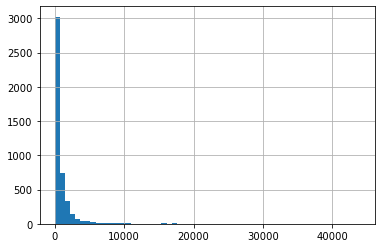

In [226]:
new_model_data['booking_number'].hist(bins=60)

In [227]:
outlier = new_model_data['booking_number'].quantile(0.95)
outlier

3370.9999999999945

In [228]:
new_model_data['booking_number'] = np.where(new_model_data['booking_number']>outlier,outlier,new_model_data['booking_number'])


<h4> As the data is skewed, taking a log transform</h4>

<AxesSubplot:>

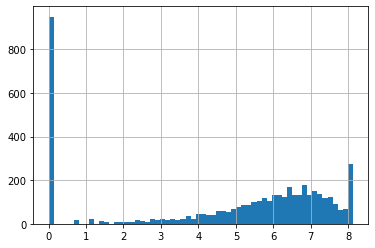

In [229]:
np.log(new_model_data['booking_number']+1).hist(bins=60)

In [230]:
new_model_data['hex_lat'] = new_model_data['hex9'].apply(lambda x: h3.h3_to_geo(x)[0])
new_model_data['hex_lng'] = new_model_data['hex9'].apply(lambda x: h3.h3_to_geo(x)[1])

<h4> Creating a 'distance' feature between the centroid of the Hex and the outlet location</h4>

<p> This helps us understand if being farther away from an outlet impacts the bookings</p>

In [231]:
new_model_data['distance'] = new_model_data.apply(lambda x: haversine(x['longitude'],x['latitude'],x['hex_lng'],x['hex_lat']),axis=1)


In [236]:
new_model_data['log_dv'] = np.log(new_model_data['booking_key']+1)

In [239]:
to_drop = ['feature_39', 'feature_5', 'feature_26', 'feature_25', 'feature_32', 'feature_34', 'feature_2',
'feature_12','feature_21', 'feature_7', 'feature_24', 'feature_7', 'feature_29', 'feature_2', 'feature_6',
'feature_12','feature_23', 'feature_22', 'feature_1', 'feature_7', 'feature_8', 'feature_37', 'feature_5',
'feature_8','feature_28', 'feature_45', 'feature_13', 'feature_43', 'feature_19', 'feature_18', 'feature_22', 
'feature_23']


feats = new_model_data.drop(to_drop,axis=1).columns.tolist()

X = new_model_data[feats]
y = new_model_data['log_dv']

from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state = 17)

X_train_copy = X_train.copy()


# standard scale the features

scaling_features = StandardScaler()
scaling_fit = scaling_features.fit(X_train[feats])
X_train_scaled = scaling_fit.transform(X_train[feats])
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train[feats].columns
X_train = X_train_scaled

X_holdout_scaled = scaling_fit.transform(X_holdout[feats])
X_holdout_scaled = pd.DataFrame(X_holdout_scaled)
X_holdout_scaled.columns = X_holdout[feats].columns
X_holdout = X_holdout_scaled


model = Lasso(alpha=0.1, random_state = 17).fit(X_train,y_train)


print(r2_score(y_train, model.predict(X_train)), r2_score(y_holdout, model.predict(X_holdout)))
print(r2_score(y_train, model.predict(X_train)), r2_score(y_holdout, model.predict(X_holdout)))
imp = pd.DataFrame(data={'features':X_train.columns,
                   'coef': model.coef_
                  }).sort_values(by='coef',ascending=False)
print(len(np.round(imp[imp['coef']!=0],5)))

0.5017755798227332 0.5015005556712534
0.5017755798227332 0.5015005556712534
31


<h4> The model achieves a R2 value of 0.5 for both train and test sets at an alpha of 0.1</h4>

<p> This shows that the model is robust in nature, needing just 31 features for the training</p>

In [240]:
imp[imp['coef']!=0]

,features,coef
582,bldg_area_total_perc_200,0.602705
171,cn_fxb_int_spd_d_1000,0.246421
469,p_residence_ap_nc_200,0.236644
576,bldg_area_comm_avg_200,0.170584
404,p_restaurant_cta_200,0.126764
286,p_residence_ap_nc_500,0.098243
257,p_entertainment_pk_nc_500,0.095591
312,p_residence_rs_nc_500,0.094272
588,bldg_area_total_perc_100,0.070429
277,p_restaurant_rt_nc_500,0.034911


<h4> As we can observe, along with other features, distance comes out to be negatively impacting the bookings, which implies users prefer booking at an outlet near their location</h4>

<h3> Predictions</h3>

In [241]:
to_predict = features.copy(deep=True)
to_predict = to_predict.dropna().reset_index(drop=True)
to_predict['distance'] = 1

to_predict_scaled = scaling_fit.transform(to_predict[feats])
to_predict_scaled = pd.DataFrame(to_predict_scaled)
to_predict_scaled.columns = X_train.columns

to_predict_scaled['log_preds'] = model.predict(to_predict_scaled)
to_predict_scaled['preds'] = np.exp(to_predict_scaled['log_preds'])-1

to_predict_scaled['preds'] = np.where(to_predict_scaled['preds']>outlier,outlier,to_predict_scaled['preds'])

to_predict_scaled['hex9'] = to_predict['hex9']

In [242]:
to_predict_scaled['preds'] = np.where(to_predict_scaled['preds']<0,0,to_predict_scaled['preds'])
to_predict_scaled['preds_perc'] = to_predict_scaled['preds']/to_predict_scaled['preds'].sum()
to_predict_scaled['tam'] = to_predict_scaled['preds_perc'] * 2000000

<h4> The above TAM number of 20,00,000 is an approximation of the total number of people that can be a customer</h4>

<p> This number can be varied based on business discussions, market research and demographic analysis</p>